## PyFolding SI Notebook 4
---

[Authors] ERGM, ARL

---

## Fitting tANK chevron to Three State with fast phase chevron - sharing parameters between models

In this notebook, let's try to fit a complicated model to some example data. Here the idea is to fit two models to two datasets, but share some of the parameters between the two models. In real terms this is difficult to do in most bought fitting software, but we have the full power of a programming language at our disposal.

We can *repurpose* (i.e. hack) the GlobalFit object to do exactly what we want. Let's start by getting some nice data digitised from this paper:

```
Structural insights into an equilibrium folding intermediate of an archaeal ankyrin repeat protein
Low C, Weininger U, Neumann P, Klepsch M, Lilie H, Stubbs MT, and Balbach J
PNAS (2008) 105: 3779–3784
```
[http://www.pnas.org/􏰂cgi􏰂/doi􏰂/10.1073/􏰂pnas.0710657105]

Remember, if you are less script/computer orientated, you can simply change the data paths/variables, etc for your proteins and re-run the jupyter notebook ( "Kernal/Restart & Run all" from the menu above).




### Data Format

Please see PyFolding SI Notebooks 1 and 2 for the format your data has to be in to enable this type of analysis.

In [1]:
#First off lets load pyfolding & pyplot into this ipython notebook (pyplot allows us to plot more complex figures of our results):

%matplotlib inline
import pyfolding
from pyfolding import models

# let's use some other libraries also
import matplotlib.pyplot as plt
import numpy as np

<IPython.core.display.Javascript object>

PyFolding: Jupyter autoscrolling has been disabled


In [2]:
# loading the data - The kinetics of each protein is in one .csv as per PyFolding SI Notebooks 1 and 2

pth = "../examples/tANK/"
tANK_all = pyfolding.read_kinetic_data(pth,"ChevronAll.csv")



In [3]:
# let's give this dataset a good name
tANK_all.ID = 'Thermophilic AR protein (tANK)'

Let's plot the chevron phases:

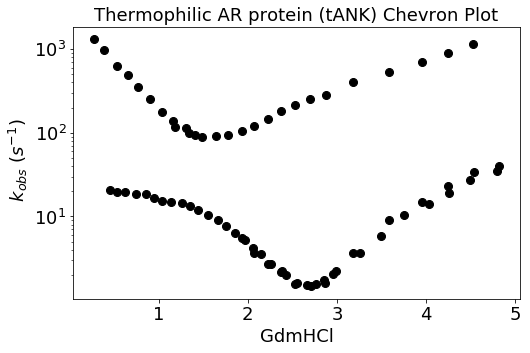

In [4]:
# easy plotting of the entire dataset ...
tANK_all.plot()

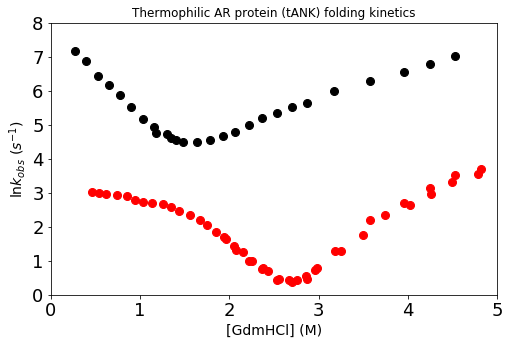

In [5]:
# ...or, custom plotting

k1_x, k1_y = tANK_all.chevron('k1')                            # defines the slower chevron rates
k2_x, k2_y = tANK_all.chevron('k2')                            # defines the faster chevron rates

plt.figure(figsize=(8,5))                                      # makes the figure 8cm by 5cm
plt.plot(k1_x, k1_y, 'ro', markersize=8)                       # red filled circles, sized '8'
plt.plot(k2_x, k2_y, 'ko', markersize=8)                       # black filled circles, sized '8'
plt.rc('xtick', labelsize=14)                                  # fontsize of the x tick labels
plt.rc('ytick', labelsize=14)                                  # fontsize of the y tick labels
plt.ylim([0, 8])                                               # y axis from 0 to 8
plt.xlim([0, 5])                                               # x axis from 0 to 5
plt.grid(False)                                                # no grid on the graph
plt.xlabel('[GdmHCl] (M)', fontsize=14)                        # x axis title with fontsize
plt.ylabel(r'$\ln k_{obs}$ $(s^{-1})$', fontsize=14)           # y axis title with fontsize
plt.title('Thermophilic AR protein (tANK) folding kinetics')   # Plot title
plt.show()


Note that the measurements were performed at $15^\text{o}$C, so we need to adjust the temperature:

In [6]:
pyfolding.set_temperature(15.0)

Set temperature to 15.00°C
(NOTE: Careful, this sets the temperature for all subsequent calculations)


Let's use the three state chevron with fast phase. To do this, we need to share the parameters like this:

1. Fit a "two-state chevron" model to the fast phase, and share those params with:
2. A "three-state with fast phase" model for the slower phase

In [7]:
models.TwoStateChevron().print_equation()

<IPython.core.display.Math object>

In [8]:
models.ThreeStateFastPhaseChevron().print_equation()

<IPython.core.display.Math object>

/Users/ergm/anaconda/lib/python2.7/site-packages/pyfolding/models.py:691: RuntimeWarning: invalid value encountered in log
  return np.log(y)


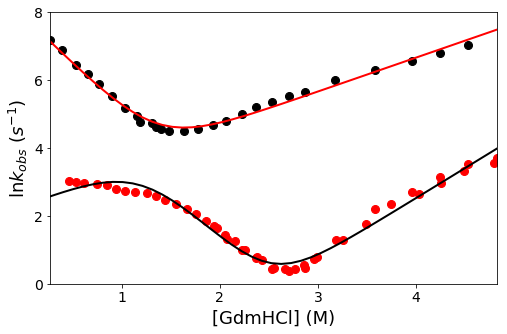

In [9]:
# start by setting up a GlobalFit object
global_fit = pyfolding.GlobalFit()
global_fit.fit_funcs = (models.TwoStateChevron, models.ThreeStateFastPhaseChevron)

# set some reasonable starting parameters for the fit
p0 = np.array([2000., 2.3, 20., 1.3, 100., 1., 0.3, 1.7])

# remember that k1 defines the slower chevron rates & k2 defines are faster chevron rates
global_fit.x = (k2_x, k1_x)

x = np.append(k2_x, k1_x)
y = np.append(k2_y, k1_y)

# import a fit function
from scipy.optimize import curve_fit 

# fit the curve
out = curve_fit(global_fit, x, y, p0=p0, maxfev=20000)
cov = out[1]

# now use the FitModel to evaluate the final parameters
fit_x = np.linspace(0., 10., 100)
f = models.ThreeStateFastPhaseChevron()
fit_y = f(fit_x, *list(out[0]))
components = f.components(fit_x, *list(out[0]))

# now that we've fitted the data, plot a figure
plt.figure(figsize=(8,5))
plt.plot(k1_x, k1_y, 'ro', markersize=8)
plt.plot(k2_x, k2_y, 'ko', markersize=8)
plt.plot(fit_x, fit_y, 'k-', linewidth=2)

for c in components:
    plt.plot(fit_x, np.log(components[c]), 'r-', linewidth=2)
#plt.ylim([0, 8])
plt.xlim([min(x), max(x)])
plt.rc('xtick', labelsize=18)    # fontsize of the x tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the y tick labels
plt.grid(False)
plt.xlabel('[GdmHCl] (M)', fontsize=18)
plt.ylabel(r'$\ln k_{obs}$ $(s^{-1})$', fontsize=18)
plt.ylim([0, 8])
plt.show()

In [10]:
# print out the fit values
print zip(f.fit_func_args, out[0])

[('kui', 2652.1825354191596), ('mui', 2.8288982702625991), ('kiu', 14.306881534291394), ('miu', 0.99905938090353419), ('kif', 1860.5222467103074), ('mif', 2.7382990177852529), ('kfi', 0.010566594989254679), ('mfi', 1.7679476843523723)]


---
### We can also output this with the  "prettier" graphics showing chevron & equilibrium curves together
(as in PyFolding SI Notebook 1)

### 1st  - we have to set up a fit result object

In [11]:
fit = pyfolding.FitResult(fit_name=f.fit_func, fit_args=f.fit_func_args)
fit.ID = tANK_all.ID
fit.method = "GlobalFit and scipy.optimize.curve_fit"
fit.fit_params = np.array( f.get_fit_params(fit_x, *list(out[0])) )
fit.y = np.exp(fit_y)
fit.residuals =  f(np.array(k1_x), *list(out[0])) - k1_y
fit.r_squared = pyfolding.r_squared(y_data=k1_y, y_fit=f(np.array(k1_x), *list(out[0])))
fit.covar = cov


In [12]:
tANK_all.results = fit
tANK_all.components = components
tANK_all.fit_func = models.ThreeStateFastPhaseChevron

### 2nd - lets get the equilibrium data & fit to a three state model

 Fitting results 
ID: tANK_equilmFluorscence
Model: ThreeStateEquilibrium
Method: scipy.optimize.curve_fit 

Y_N: 	 324.75027 ± 0.74190 	 95% CI[324.56451, 324.93603]
Y_I: 	 197.11446 ± 3.56063 	 95% CI[196.22293, 198.00599]
Y_D: 	 66.56156 ± 0.75910 	 95% CI[66.37149, 66.75162]
DGni: 	 4.77711 ± 0.21538 	 95% CI[4.72318, 4.83104]
m_ni: 	 2.96838 ± 0.14905 	 95% CI[2.93106, 3.00570]
DGid: 	 8.33336 ± 0.44659 	 95% CI[8.22154, 8.44518]
m_id: 	 3.09530 ± 0.15594 	 95% CI[3.05626, 3.13435]
---------------------------------------------------------------------------
R^2: 0.99983


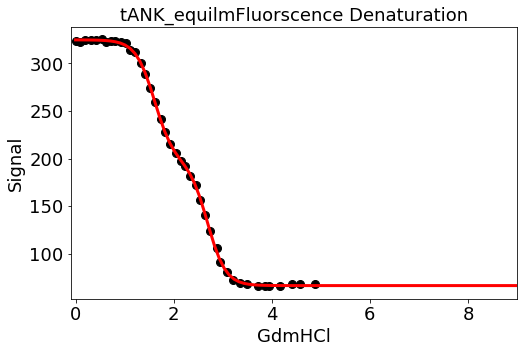

In [13]:
#1st load the data by adding the equilibrium
tank_Equilm = pyfolding.read_equilibrium_data(pth, "tANK_equilmFluorscence.csv")

#then select the fit function and associate it with the data
tank_Equilm.fit_func = models.ThreeStateEquilibrium

# Fit it with parameters (as the defaults ones are not close enough)
tank_Equilm.fit(p0=[350,2,25,18.5,11.6,34,12.6])

# Plot the figure to check
tank_Equilm.plot()


### 3rd - lets plot both together & print out to pdf

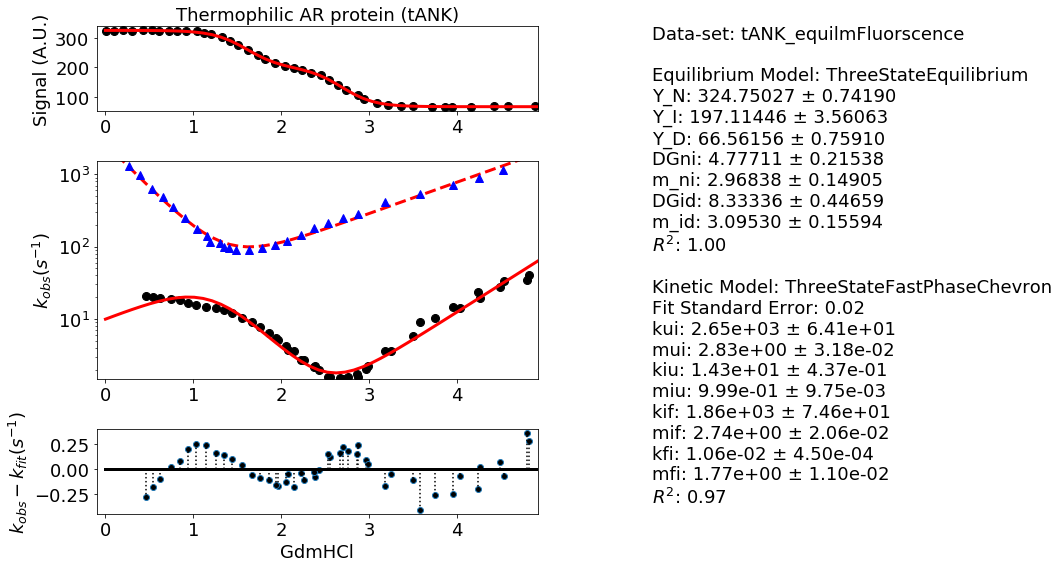

In [14]:
pyfolding.plot_figure(tank_Equilm, tANK_all, display=True, pth='/users/ergm/', save=True)


---

### End of this Notebook.

---